# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Line Finding on the Road 

***

## Overview
In this project, overall goal is to create a software pipeline to identify the lane boundaries in a video recorded from a front-facing camera on a car. 

## Goals / Steps
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
***

## Import Packages

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip

## Camera Calibration

In [17]:
def camera_calibration(imgs,nx=9,ny=6):
    #prepare object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] #3d points in real world space
    imgpoints = [] #2d points in image plane
    
    for files in imgs:
        img = cv2.imread(files)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #find chessboard corners
        ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if len(objpoints)> 0:
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
        print('Camera Calibraion Successful!')
    else:
        ret,mtx,dist,rvecs,tvecs = None,None,None,None,None
        print('Camera Calibarion Unsuccessful!')
    return ret,mtx,dist,rvecs,tvecs

In [18]:
# Get calibration coefficient using calibration function and images
images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = camera_calibration(images)

Camera Calibraion Successful!


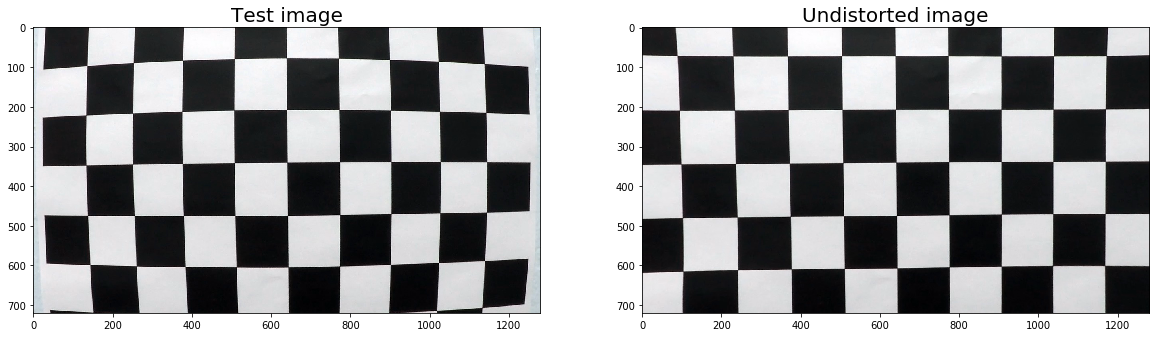

In [134]:
# Test image and undistorted image using calibration coefficient
test_img = cv2.imread('./camera_cal/calibration1.jpg')
undist_img = cv2.undistort(test_img,mtx,dist,None,mtx)

# helper function for ploting two images
def plt_images(img_1, title_1, img_2, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=20)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=20)
    ax2.imshow(img_2)
    
plt_images(test_img, 'Test image', undist_img, 'Undistorted image')

## Color transform & Gradient

In [4]:
def calculate_gradient(image,kernel_size):
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=kernel_size)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=kernel_size)
    return sobelx,sobely

def apply_mask(sobel,threshold):
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary = apply_non_scaled_mask(scaled_sobel,threshold)
    return binary

def apply_non_scaled_mask(sobel,threshold):
    binary = np.zeros_like(sobel)
    binary[(sobel>=threshold[0])&(sobel<=threshold[1])] = 1
    return binary
def abs_sobel_thresh(image,orient='x',threshold=(0,255)):
    
    if orient=='x':
        sobel = np.absolute(cv2.Sobel(image,cv2.CV_64F,1,0))
    elif orient =='y':
        sobel = np.absolute(cv2.Sobel(image,cv2.CV_64F,0,1))
    else:
        raise"Invalid value for orient:{}".format(orient)
    binary = apply_mask(sobel,threshold=threshold)
    return binary

def mag_thresh(img,sobel_ksize=3,threshold=(0,255)):
    sobelx, sobely = calculate_gradient(img,sobel_ksize)
    magxy = np.sqrt(sobelx**2+sobely**2)
    binary = apply_mask(magxy,threshold=threshold)
    return binary
                     
def dir_thresh(img,sobel_ksize=3,threshold=(0,np.pi/2)):
    sobelx, sobely = calculate_gradient(img,sobel_ksize)
    direction = np.arctan2(np.absolute(sobelx),np.absolute(sobely))
    binary = apply_non_scaled_mask(direction,threshold=threshold)
    return binary
                     

In [99]:
def edge_detection(image):
    
    #get R channel from BGR image
    r_channel = image[:,:,2]
    #convert image to HLS space
    hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS).astype(np.float)
    #get s channel
    s_channel = hls[:,:,2]
    #S channel generally does good job on detecting lane edges. However, since 
    # R channel sometimes do better job on detecting white lanes, we will combine R and S channel
    # for detecting lane
    zeros = np.zeros((image.shape[:2]),dtype='uint8')
    #rs = cv2.merge([zeros,r_channel,s_channel])
    # get gradient mask
    s_channel_grad_mask = get_grad_mask(s_channel,(40,100),(35,100),(np.pi/5,np.pi/2))
    s_channel_color_mask= apply_non_scaled_mask(s_channel,threshold=(200,255))
    r_channel_grad_mask = get_grad_mask(r_channel,(40,100),(25,120),(np.pi/5,np.pi/2))
    r_channel_color_mask = apply_non_scaled_mask(r_channel,threshold=(220,240))
    return r_channel,s_channel,r_channel_grad_mask,r_channel_color_mask, s_channel_grad_mask, s_channel_color_mask

def get_grad_mask(img,abs_threshold,mag_threshold,dir_threshold):
    abs_grad_x = abs_sobel_thresh(img,orient='x',threshold=abs_threshold)
    abs_grad_y = abs_sobel_thresh(img,orient='y',threshold=abs_threshold)
    mag_grad = mag_thresh(img,threshold=mag_threshold)
    dir_grad = dir_thresh(img,threshold=dir_threshold)
    grad_mask = np.zeros_like(img)
    grad_mask[((abs_grad_x==1)&(abs_grad_y==1))|((mag_grad==1)&(dir_grad==1))]=1
    return grad_mask
                    

def color_binary(image):
    r_channel,s_channel,r_channel_grad_mask,r_channel_color_mask, s_channel_grad_mask, s_channel_color_mask = edge_detection(image)
    binary = np.dstack((np.zeros_like(r_channel),r_channel_grad_mask,r_channel_color_mask))
    binary1 = np.dstack((np.zeros_like(s_channel),s_channel_grad_mask,s_channel_color_mask))
    binaryfinal = np.concatenate((binary,binary1),axis=0)
    return binaryfinal

def combined_binary(image):
    r_channel,s_channel,r_channel_grad_mask,r_channel_color_mask, s_channel_grad_mask, s_channel_color_mask = edge_detection(image)
    binary = np.zeros_like(s_channel_grad_mask)
    binary[((r_channel_color_mask==1)|(r_channel_grad_mask==1))|((s_channel_color_mask==1)|(s_channel_grad_mask==1))]=1
    return binary
    

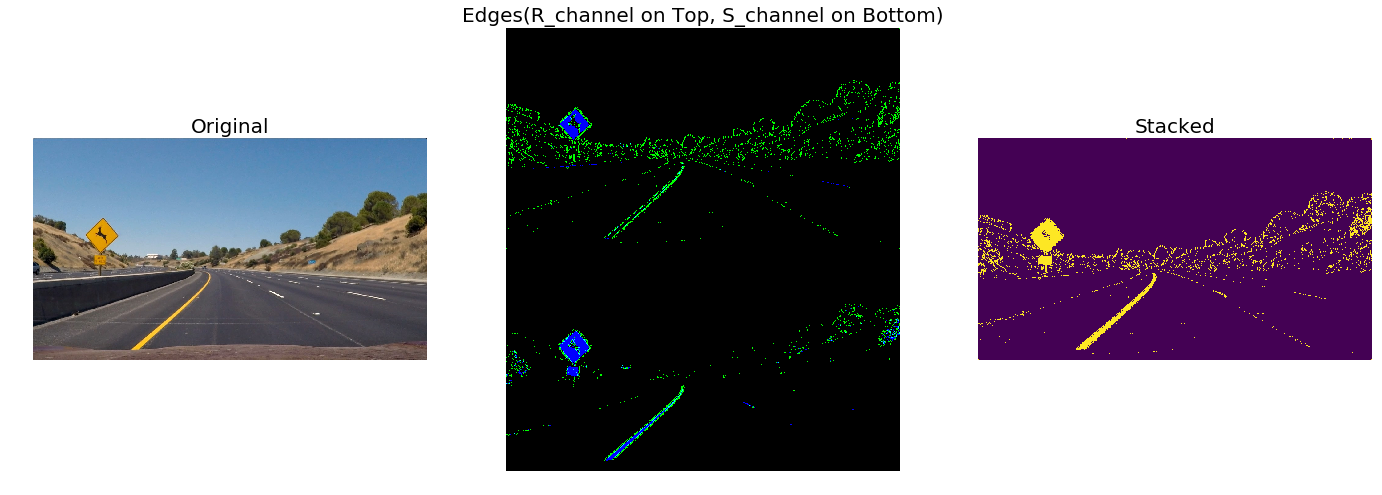

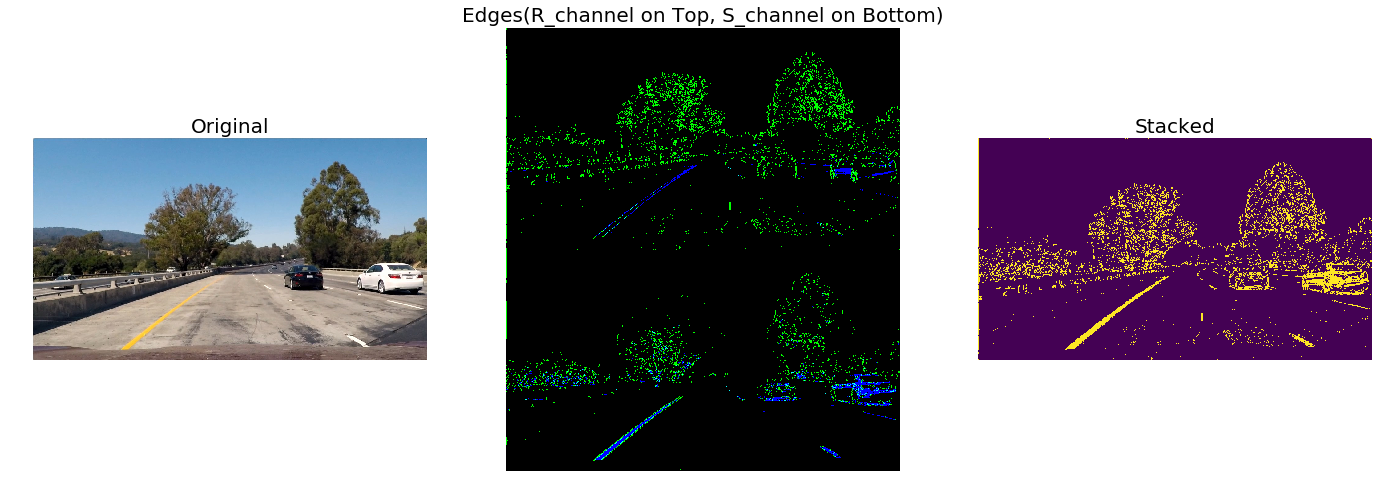

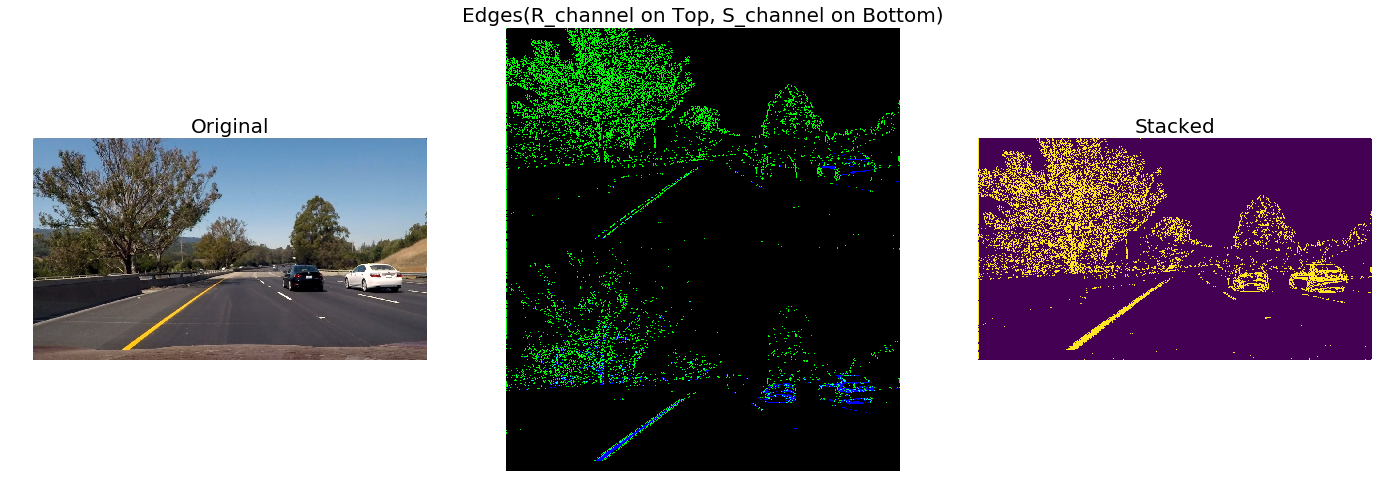

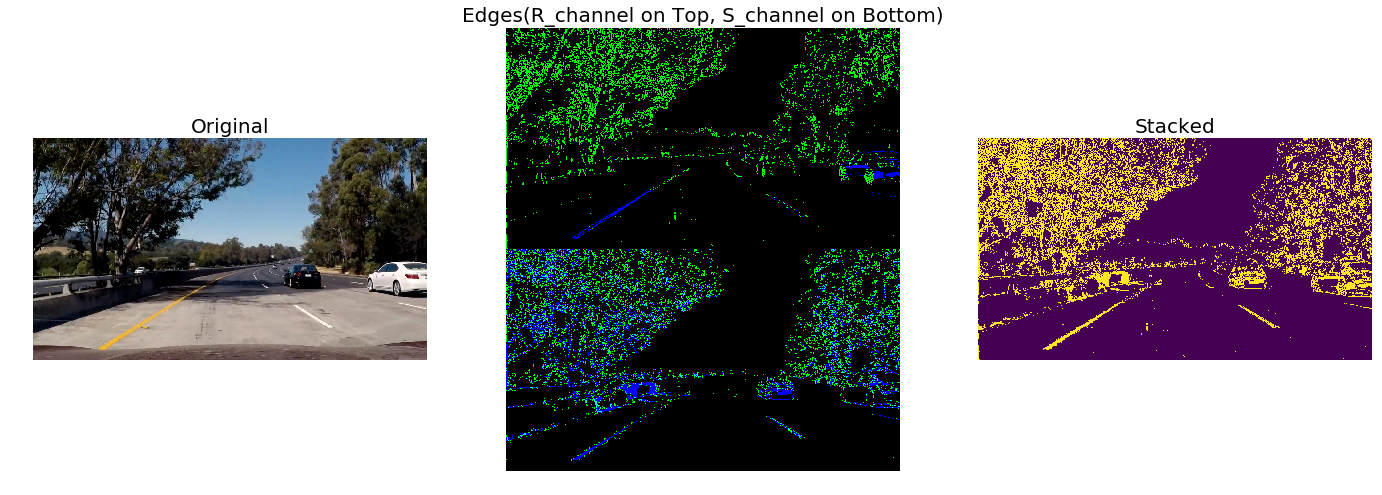

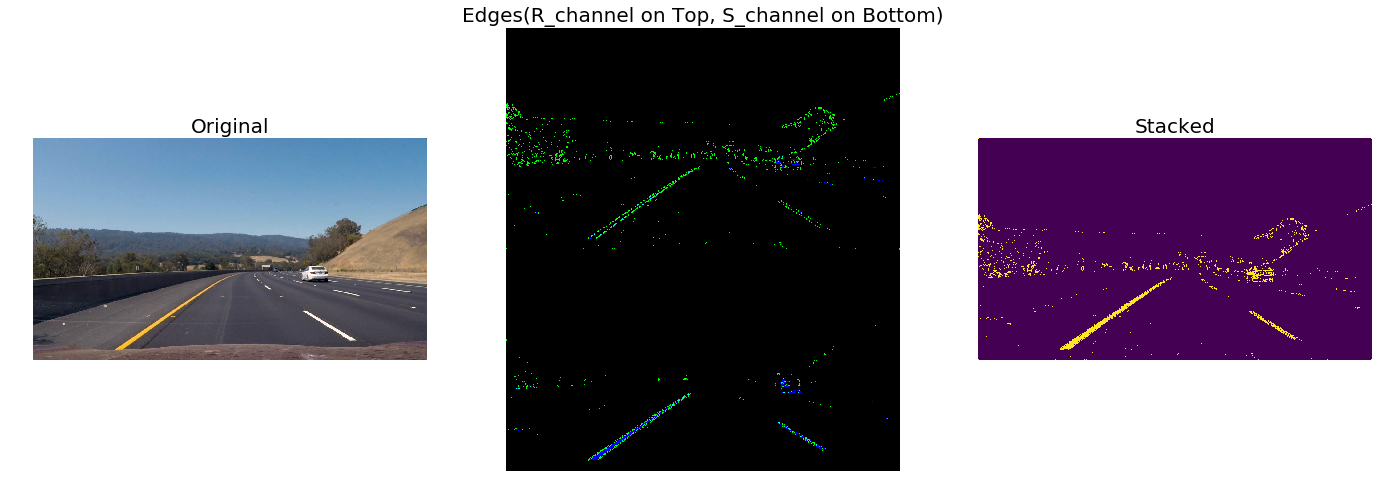

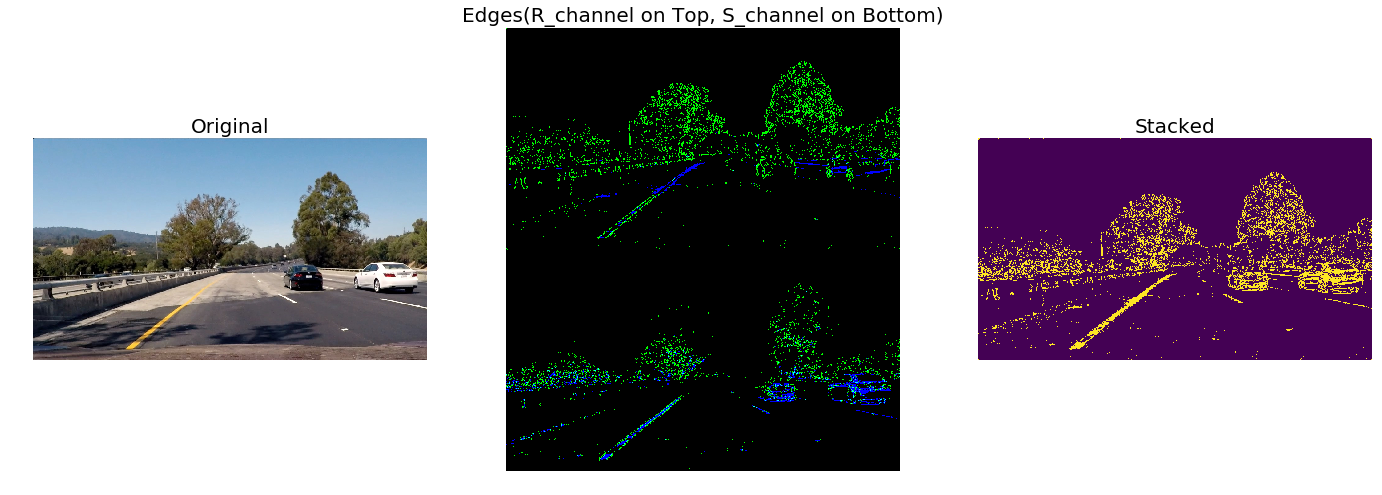

In [100]:
for image in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image)
    original = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    edges = color_binary(image)
    stack = combined_binary(image)

    f, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(original)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(edges)
    x2.set_title('Edges(R_channel on Top, S_channel on Bottom)', fontsize=20)
    
    x3.axis('off')
    x3.imshow(stack)
    x3.set_title('Stacked', fontsize=20)

## Perspective Transform

First of all lets get source and destination points for perspective transform, using straight lane image.

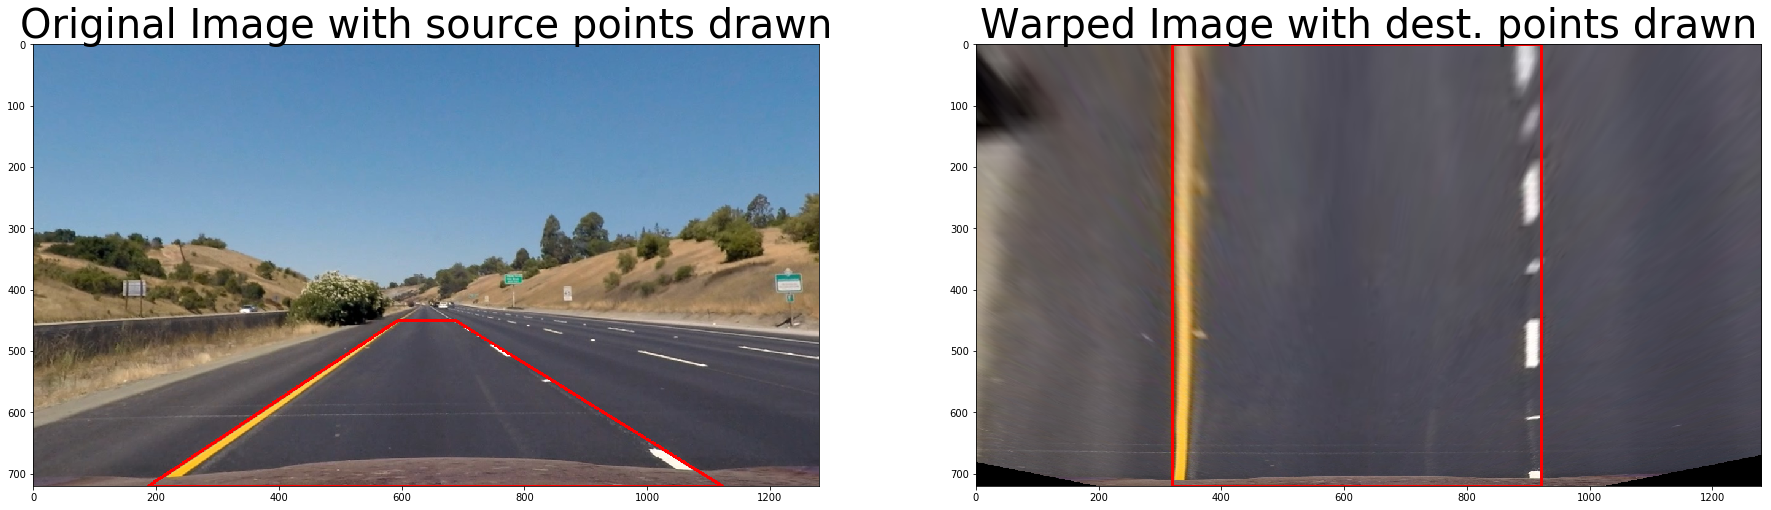

In [65]:
perspective_test_img = cv2.imread('test_images/straight_lines1.jpg')
perspective_test_rgb = cv2.cvtColor(perspective_test_img,cv2.COLOR_BGR2RGB)
undist_perspective_test_rgb = cv2.undistort(perspective_test_rgb,mtx,dist,None,mtx)

height,width,_= undist_perspective_test_rgb.shape
#Pick source image points manually
top_left = [593, 450]
top_right = [688, 450]
bottom_right = [1123, 720]
bottom_left = [187,720]
src = np.float32([top_left,top_right,bottom_right,bottom_left])
src2pts = np.array([top_left,top_right,bottom_right,bottom_left])
copy = perspective_test_rgb.copy()
cv2.polylines(undist_perspective_test_rgb,[src2pts],True,(255,0,0), thickness=3) #Draw lines on where picked points are at
#Pick destination image points manually
dst_top_left = [320,1]
dst_top_right= [920,1]
dst_bottom_left = [320,720]
dst_bottom_right = [920,720]
dst = np.float32([dst_top_left,dst_top_right,dst_bottom_right,dst_bottom_left])
dst2pts = np.array([dst_top_left,dst_top_right,dst_bottom_right,dst_bottom_left])
M = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(copy,M,(width,height))
cv2.polylines(warped,[dst2pts],True,(255,0,0),thickness=3) # Draw line on warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(undist_perspective_test_rgb)
ax1.set_title('Original Image with source points drawn', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image with dest. points drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [66]:
def perspective_transform_with_calibration(image,mtx,dist):
    height,width,_= image.shape
    undist_img = cv2.undistort(image,mtx,dist,None,mtx)
    src = np.float32([[593,450],[688,450],[1123,720],[187,720]])
    dst = np.float32([[320,1],[920,1],[920,720],[320,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(undist_img,M,(width,height))
    return warped, M

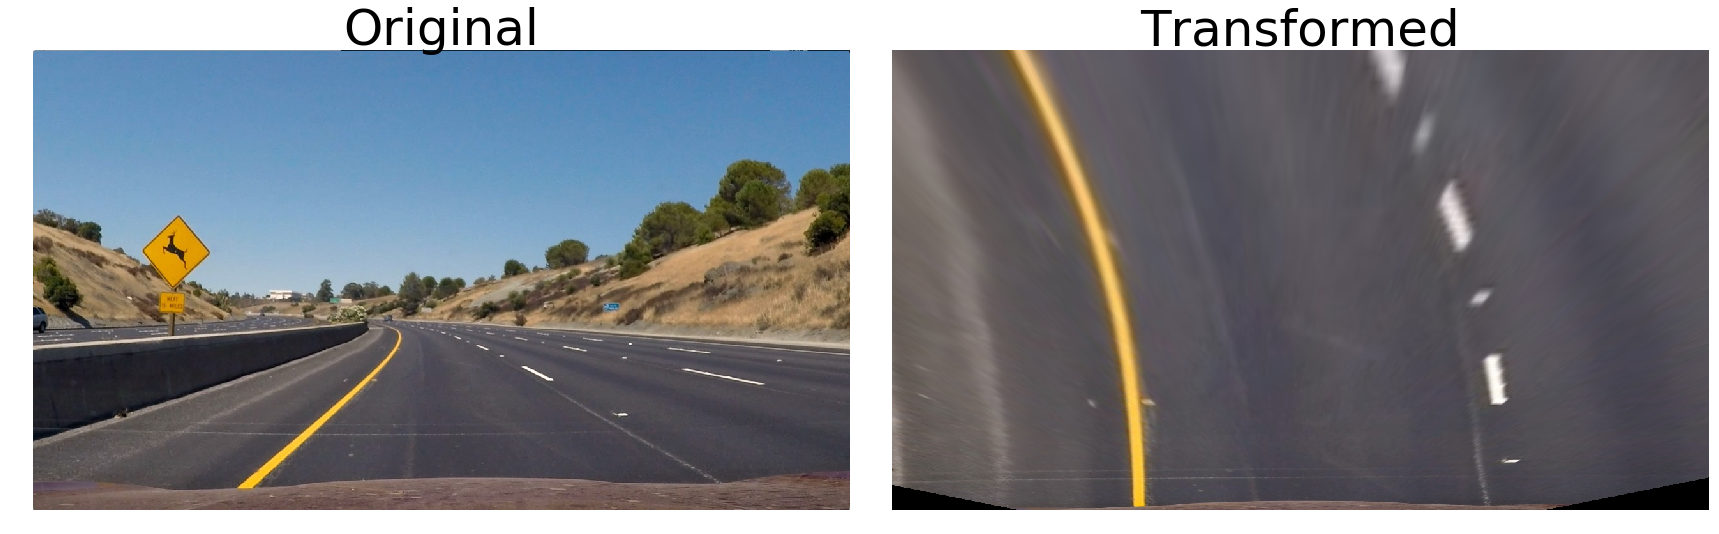

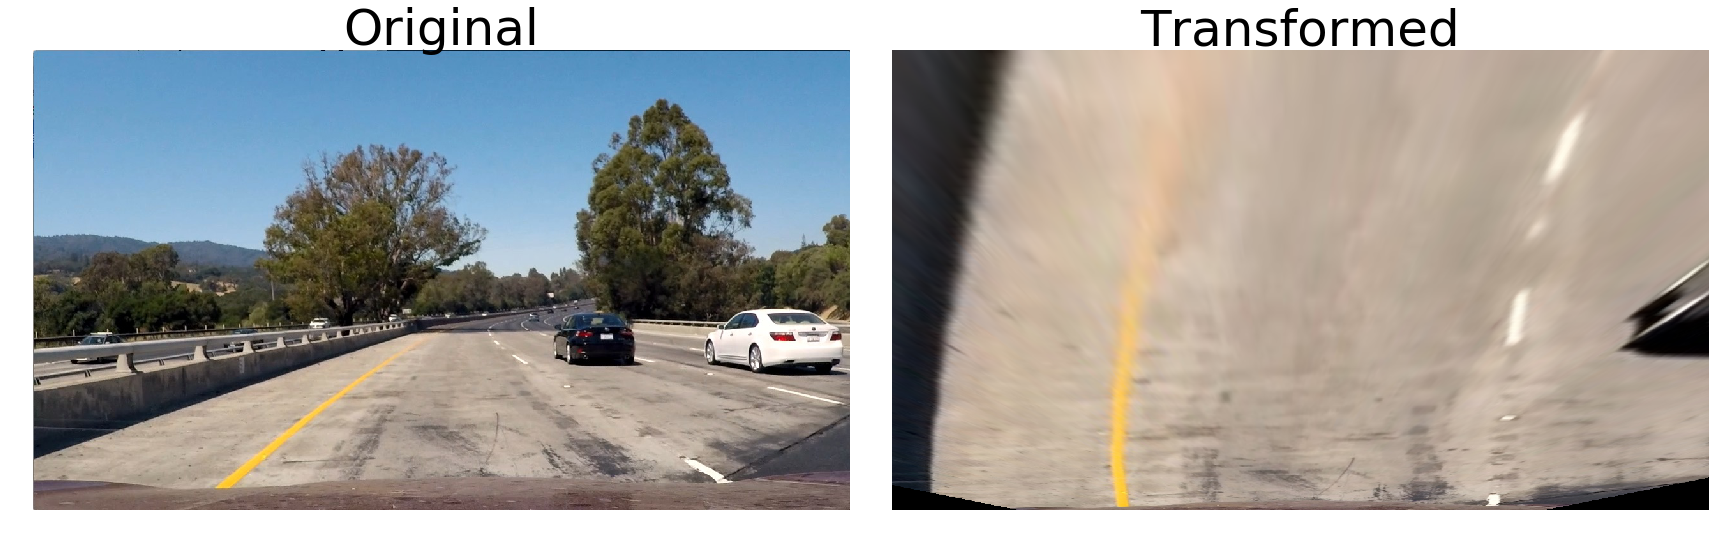

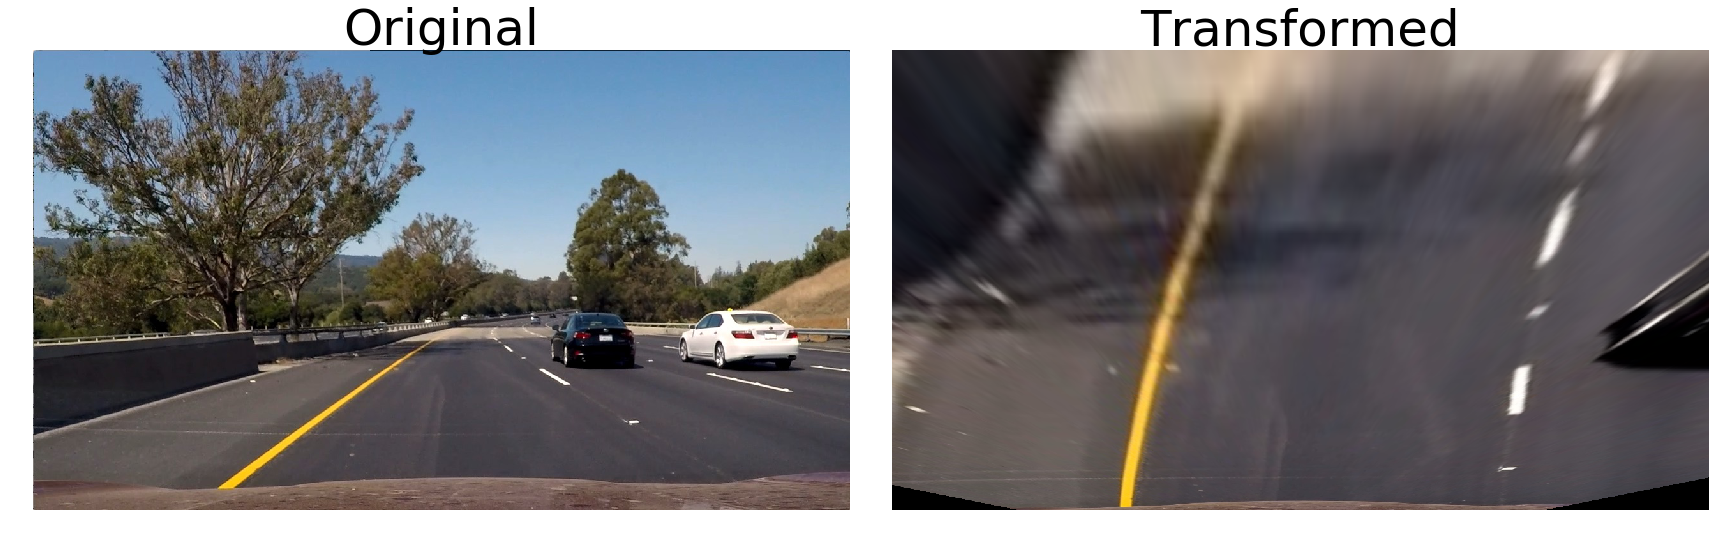

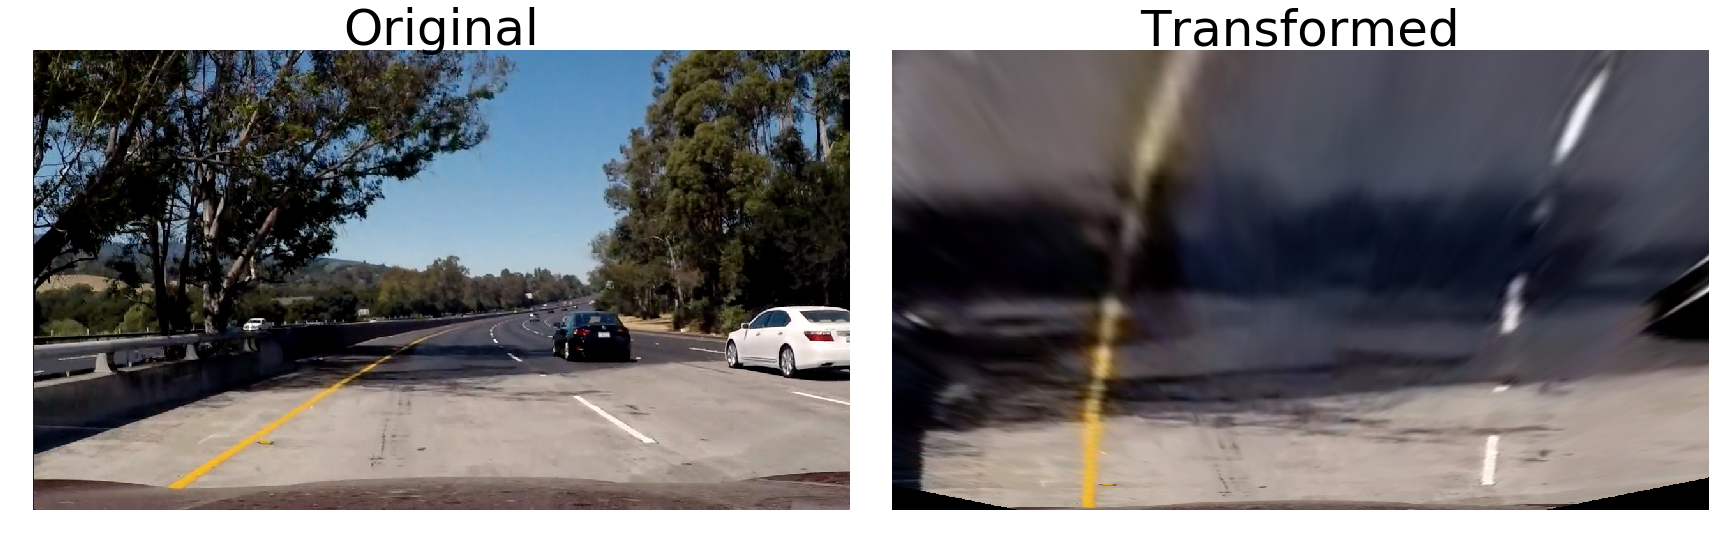

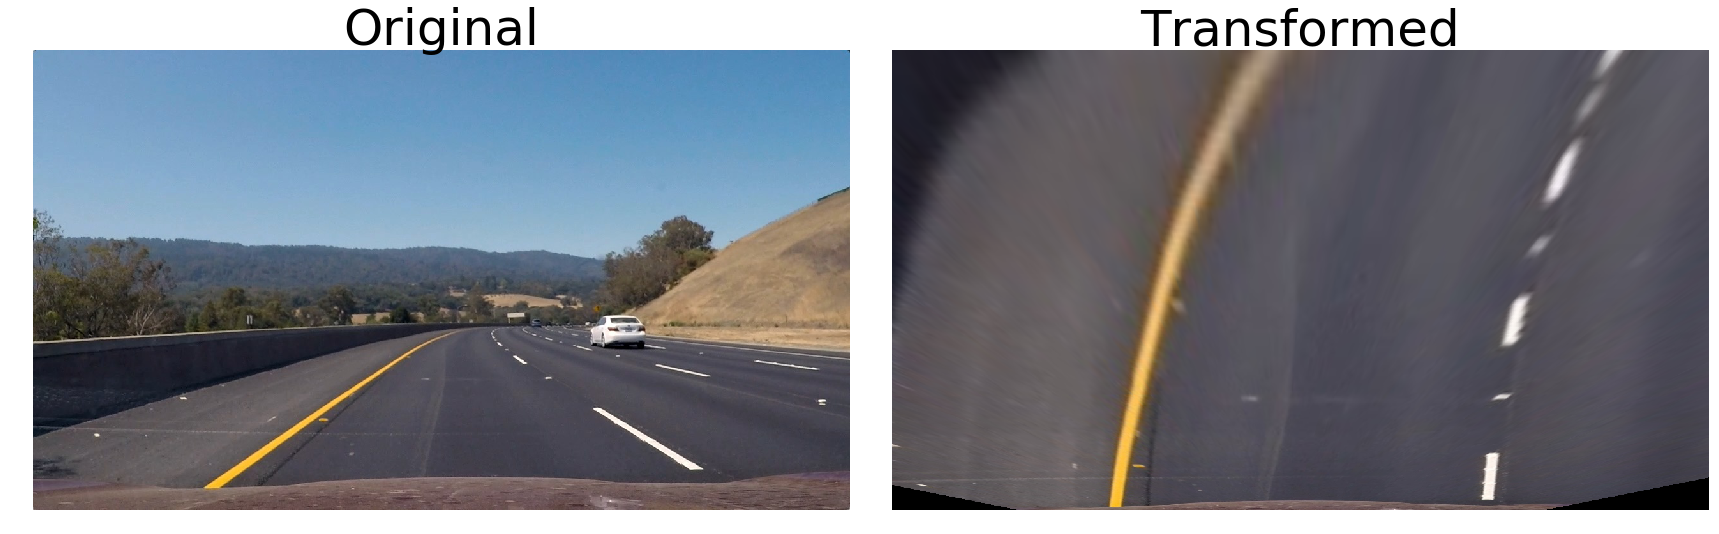

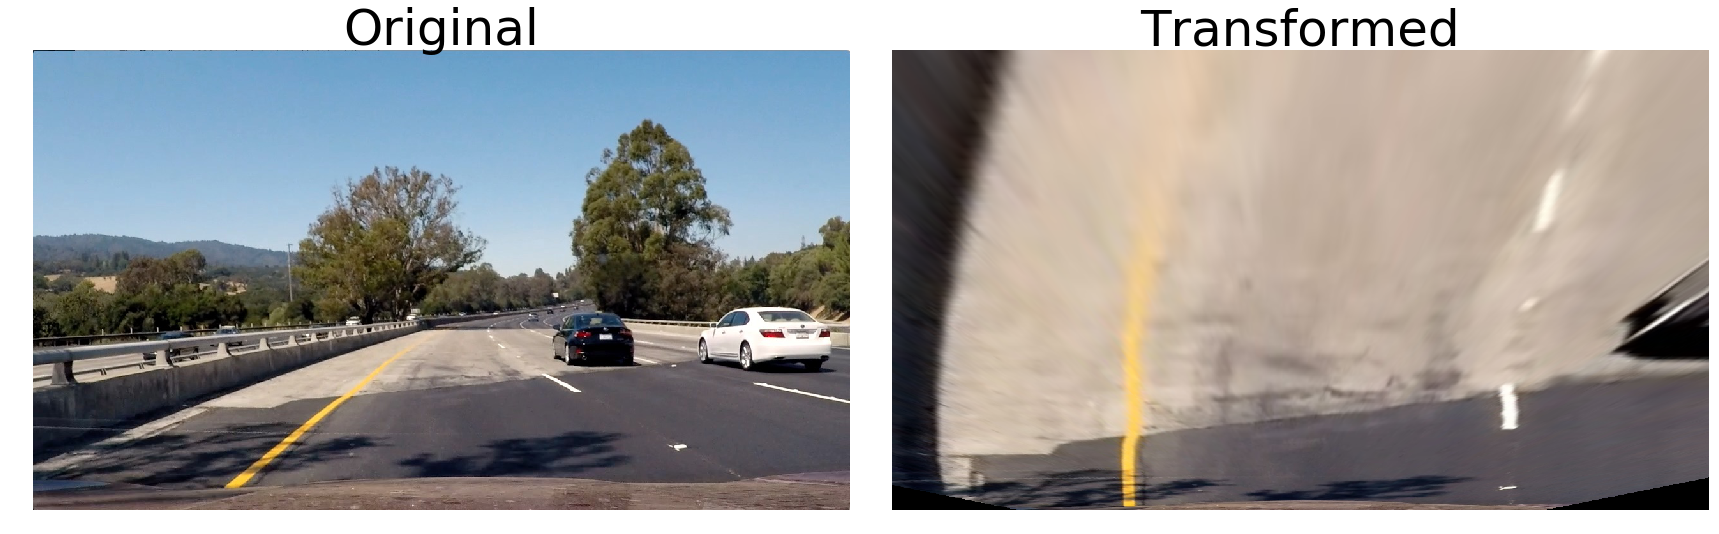

In [67]:
for image in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image)
    rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    warped, M = perspective_transform_with_calibration(rgb,mtx=mtx,dist=dist) 
    
    f, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    x1.axis('off')
    x1.imshow(rgb)
    x1.set_title('Original', fontsize=50)

    x2.axis('off')
    x2.imshow(warped)
    x2.set_title('Transformed', fontsize=50)

## Lane Pixel Detection

In [ ]:
def find_lane_base(binary_warped_img):
    # Get histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:],axis=0)
    
    # Get peak pixel value for left and right lane
    #Set mid point, left_base and right_base
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    return leftx_base, rightx_base

In [71]:
class sliding_window(object):
    def __init__(self,img,y_low,y_high,x_mid,margin=100,minpix=50):
        self.x = x_mid
        self.x_init = x_mid
        self.y_low = y_low
        self.y_high = y_high
        self.margin = margin
        self.minpix = minpix
        self.nonzero = img.nonzero()
        self.winx_low = self.x - margin
        self.winx_high = self.x + margin
    def lane_inds(self,window=None):
        lane_ind = ((self.nonzero[0]>=self.y_high)&(self.nonzero[0]<self.y_low)&\
                   (self.nonzero[1]>=self.winx_high)&(self.nonzero[1]<self.winx_low)).nonzero()[0]
        if len(lane_ind)>self.minpix:
            self.x = np.int(np.mean(self.nonzero[1][lane_ind]))
        else:
            self.x = self.x_init
        return lane_inds
    def vertice(self):
        return ((self.winx_low,self.y_low),(self.winx_high,self.y_high))
        

In [ ]:
class Lane_curvature(object):
    def __init__(self,x,y,img_width,img_height):
        self.width = img_width
        self.height = img_height
        self.fit = np.polyfit(y,x,2)
        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/720
    def generate_lane_points(self):
        ploty=np.linspace(0,self.height-1,self.height)
        fit = (self.fit[0]*ploty**2+self.fit[1]*ploty+self.fit[2])
        return fit
    def curvature(self):
        pts = self.generate_lane_points()
        x = pts[:,0]
        y = pts[:,1]

In [72]:
class pipeline(object):
    def __init__(self,frame,nwindows=9):
        self.height = frame.shape[0]
        self.width = frame.shape[1]
        self.nwindows = nwindows
        self.leftx_update =[]
        self.rightx_update = []
        
    def _init_lane(self,frame):
        edges = combined_binary(frame)
        perspective_edge = perspective_transform_with_calibration(image,mtx,dist)
        histogram = np.sum(perspective_edge[int(self.height//2):,:],axis=0)
        nonzero = perspective_edge.nonzero()
        left_lane_inds = []
        right_lane_inds = []
        window_height = int(self.height//self.nwindows)
        out_img = np.dstack(perspective_edge,perspective_edge,perspective_edge)
        for window in range(self.nwindows):
            if window == 0:
                leftx_current, rightx_current = find_lane_base(perspective_edge)
            else:
                leftx_current, rightx_current = self.leftx_update[-1],self.rightx_update[-1]
                
            left_window = sliding_window(perspective_edge,y_low=self.height-(window*window_height),\
                                        y_high=self.height-(window+1)*window_hight,\
                                        x_mid = leftx_current)
            right_window = sliding_window(perspective_edge,y_low=self.height-(window*window_height),\
                                        y_high=self.height-(window+1)*window_hight,\
                                        x_mid = rightx_current)
            left_lane_inds = np.append(left_window.lane_inds())
            right_lane_inds = np.append(right_window.lane_inds())
            self.leftx_update.append(left_window.x)
            self.rightx_update.append(right_window.x)
        leftx = nonzero[1][left_lane_inds]
        lefty = nonzero[0][left_lane_inds]
        rightx = nonzero[1][right_lane_inds]
        righty = nonzero[0][right_lane_inds]
    def
            

TypeError: Image data cannot be converted to float

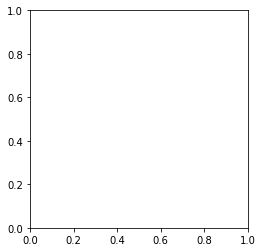

In [74]:
test = cv2.imread('test_images/test1.jpg')
process = pipeline(test)
plt.imshow(process)

In [68]:
def sliding_window(img,nwindows=9,margin=100,minpix=50):
    window_height = np.int(img.shape[0]//nwindows)
    #identify x, y position of all nonzero pixels
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[0])
    nonzeroy = np.array(nonzero[1])
    #current position at the beginning (base)
    leftx_current,rightx_current = find_lane_base(img)
    # Output image to draw and visualize the result
    out_img = np.dstack((binary_warped_img,binary_warped_img,binary_warped_img))
    #list to receive left and right pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0]-(window+1)*window_height
        win_y_high= binary_warped.shape[0]-window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high= leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_leftx_low,win_y_low),(win_leftx_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_rightx_low,win_y_low),(win_rightx_high,win_y_high),(0,255,0),2)
        
